<a href="https://colab.research.google.com/github/Vakhranev/Heritage/blob/main/%D0%9F%D0%BE%D0%B2%D1%82%D0%BE%D1%80%D1%8B%20%D0%BA%D0%BE%D0%BB%D0%BB%D0%BE%D0%BA%D0%B0%D1%86%D0%B8%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-1-33f77ee38b64>:57: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


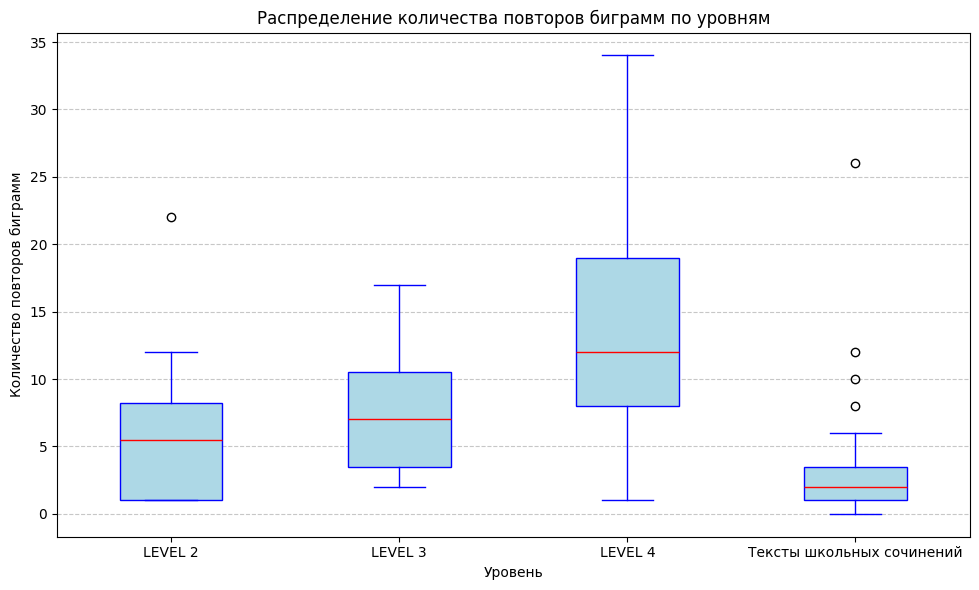


Статистика для LEVEL 2:
  Среднее = 6.10, Макс = 22, Мин = 1, Всего повторов = 122

Статистика для LEVEL 3:
  Среднее = 7.62, Макс = 17, Мин = 2, Всего повторов = 61

Статистика для LEVEL 4:
  Среднее = 14.02, Макс = 34, Мин = 1, Всего повторов = 575

Статистика для Тексты школьных сочинений:
  Среднее = 3.87, Макс = 26, Мин = 0, Всего повторов = 89


In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Функция для подсчета повторяющихся биграмм
def count_repeated_bigrams(text):
    tokens = text.split()
    bigrams = [f"{tokens[i]} {tokens[i+1]}" for i in range(len(tokens) - 1)]
    bigram_count = Counter(bigrams)
    repeated = sum(1 for count in bigram_count.values() if count > 1)
    return repeated

# Чтение данных
with open('updated_america_texts_last.json', 'r', encoding='utf-8') as f:
    america_texts = json.load(f)

with open('updated_final_school.json', 'r', encoding='utf-8') as f:
    lib_texts = json.load(f)

with open('files_by_levels.txt', 'r', encoding='utf-8') as f:
    files_by_levels = {'LEVEL 2': [], 'LEVEL 3': [], 'LEVEL 4': []}
    current_level = None
    for line in f:
        line = line.strip()
        if line.startswith('LEVEL'):
            current_level = line
        elif line and current_level:
            files_by_levels[current_level].append(line)

# Анализ данных
def analyze_by_level(files, data):
    detailed_stats = []

    for file in files:
        if file in data:
            text = data[file]['text']
            repeated = count_repeated_bigrams(text)
            detailed_stats.append(repeated)

    return detailed_stats

# Анализ для каждого уровня и художественных текстов
detailed_stats = {}

for level, files in files_by_levels.items():
    detailed_stats[level] = analyze_by_level(files, america_texts)

detailed_stats['Тексты школьных сочинений'] = analyze_by_level(lib_texts.keys(), lib_texts)

# Визуализация результатов (график с усиками)
plt.figure(figsize=(10, 6))

labels = list(detailed_stats.keys())
data = list(detailed_stats.values())

plt.boxplot(
    data,
    labels=labels,
    patch_artist=True,
    boxprops=dict(facecolor="lightblue", color="blue"),
    medianprops=dict(color="red"),
    whiskerprops=dict(color="blue"),
    capprops=dict(color="blue"),
)

plt.title('Распределение количества повторов биграмм по уровням')
plt.xlabel('Уровень')
plt.ylabel('Количество повторов биграмм')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('repeats_boxplot_analysis.png')
plt.show()

# Текстовая статистика
def print_stats(stats, label):
    if stats:
        print(f"\nСтатистика для {label}:")
        print(f"  Среднее = {np.mean(stats):.2f}, Макс = {np.max(stats)}, Мин = {np.min(stats)}, Всего повторов = {np.sum(stats)}")
    else:
        print(f"\nНет данных для {label}.")

for level, stats in detailed_stats.items():
    print_stats(stats, level)